In [44]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt

import copy


# Sample data
data = {
    'x': [1, 2, 2, 8, 8, 25],
    'y': [2, 2, 3, 8, 9, 30]
}

# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_2nuBB_slim.h5","hits")

# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim.h5","MC/hits")
hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim_smear.h5","hits")
display(hits)


,event_id,x,y,z,energy
0,0,-7.278010,5.699774,3001.824951,0.003125
1,0,-8.744831,6.098631,3002.756836,0.000600
2,0,-10.577087,6.596858,3003.920898,0.001850
3,0,-12.899525,7.228374,3005.396484,0.001500
4,0,-14.457469,7.634260,3006.411621,0.000925
...,...,...,...,...,...
1014,9,-1.566567,6.041556,2994.062988,0.001375
1015,9,-0.845645,5.452194,2995.227539,0.001700
1016,9,0.166640,4.618393,2996.852295,0.000125
1017,9,0.988774,3.951444,2998.179199,0.002775


,x,y,z,energy
0,5.413278,7.843829,3003.376465,0.005675
1,6.829153,8.839975,3005.493652,0.002225
2,7.159637,9.001612,3005.961670,0.000025
3,8.079507,9.469001,3007.347656,0.000275
4,9.065145,9.969808,3008.832764,0.000025
...,...,...,...,...
123,37.388474,45.676159,3006.521729,0.000750
124,37.735806,43.722973,3008.046387,0.001225
125,37.884079,39.100704,3012.221436,0.000275
126,38.005253,42.207756,3009.229004,0.000225


OUT: {0: [1], 1: [0, 2], 2: [1, 3], 3: [2, 4], 4: [3, 5], 5: [4], 6: [7], 7: [6], 8: [20], 20: [8, 23], 9: [10], 10: [9], 11: [12], 12: [11, 13], 13: [12], 14: [17], 17: [14, 18], 15: [16], 16: [15, 19], 19: [16, 21], 18: [17, 22], 23: [20], 21: [19, 26], 22: [18, 25], 24: [30], 30: [24, 31], 25: [22], 26: [21], 27: [34], 34: [27, 42], 28: [33], 33: [28, 39], 29: [32], 32: [29, 35], 31: [30, 45], 35: [32, 41], 39: [33], 36: [37, 40], 37: [36], 38: [48, 43], 48: [38, 52], 40: [36], 41: [35], 42: [34], 43: [38], 44: [47], 47: [44], 45: [31], 46: [49], 49: [46, 54], 52: [48, 61], 54: [49, 55], 50: [56], 56: [50], 51: [53], 53: [51, 58], 55: [54, 57], 57: [55], 58: [53], 59: [67], 67: [59, 71], 60: [63], 63: [60], 61: [52], 62: [64], 64: [62, 66], 65: [76], 76: [65, 84], 66: [64], 71: [67, 80], 68: [73], 73: [68, 74], 69: [75], 75: [69, 79], 70: [78], 78: [70, 86], 72: [77], 77: [72, 85], 74: [73], 84: [76], 86: [78, 89], 79: [75], 80: [71], 81: [92], 92: [81], 82: [88], 88: [82, 83], 83: 

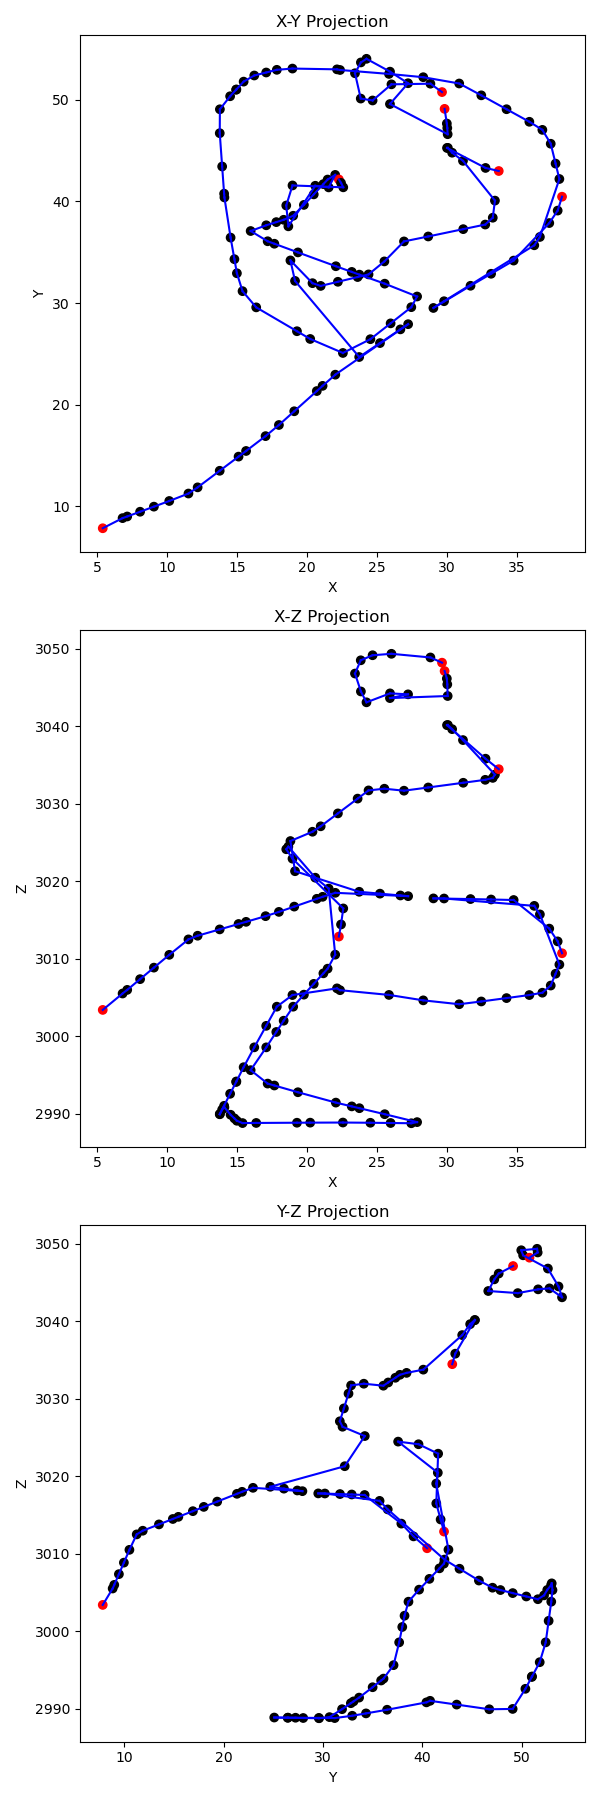

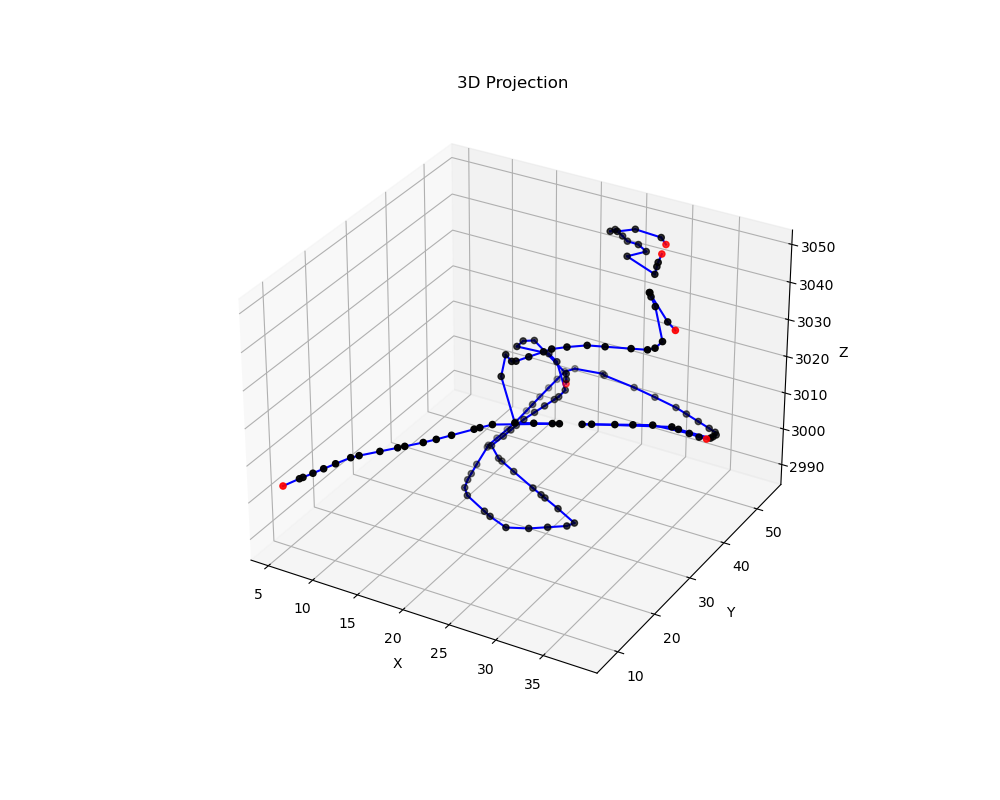

In [151]:
%matplotlib widget

data = hits[hits.event_id == 1]

# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
data = data[['x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

display(data)

df = pd.DataFrame(data)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

# Initialize connections counter, keeps track of number of connections to each index
connection_count = np.zeros(len(data), dtype=int)

# This is a dict, format is
# index : [connected node 1, connected node 2,...]
connected_nodes = {}

# Define angle threshold in degrees
angle_threshold = 0.5  # Change this value as needed
angle_threshold = np.deg2rad(angle_threshold)

# Function to calculate the angle between two vectors
def calculate_angle(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    angle = np.arccos(dot_product / (norm_v1 * norm_v2))
    return angle

# Function to add connections made
# current and current node index is input
def UpdateConnections(curr_node_idx, conn_node_idx, connected_nodes_, connections_, connection_count_):

    # We shouldnt be doing any self connection
    if (curr_node_idx == conn_node_idx):
        return

    # Add connection between node i and closest_idx
    connections_.append((curr_node_idx, conn_node_idx))
    connection_count_[curr_node_idx] += 1
    connection_count_[conn_node_idx] += 1
    
    # Update connected nodes
    if i in connected_nodes_:
        connected_nodes_[curr_node_idx].append(conn_node_idx)
    else:
        connected_nodes_[curr_node_idx] = [conn_node_idx]
    
    if conn_node_idx in connected_nodes_:
        connected_nodes_[conn_node_idx].append(curr_node_idx)
    else:
        connected_nodes_[conn_node_idx] = [curr_node_idx]

# Function to check if a new connection would form a closed loop
def forms_cycle(node, target, connections_dict):

    query = node
    prev_node = node 
    # print(query)

    for index,n in enumerate(range(len(connections_dict))):
        
        # Get the connected nodes
        con_nodes = connections_dict[query]
        # print("Start",query, prev_node, con_nodes)

        # We hit a end-point and it didnt loop
        if (len(con_nodes) == 1):
            return False

        # Get the node that went in the query before
        if con_nodes[1] == prev_node:
            prev_node = query
            query = con_nodes[0]
        else:
            prev_node = query
            query = con_nodes[1]

        if (index == 0):
            query = con_nodes[0]
            prev_node = node


        # If the returned query value is the target then we have looped
        if (query == target):
            return True

    # We looped over everything and found no loops
    return False
    


# Find closest nodes and create connections
connections = []
for i in range(len(data)):
    # Find the index of the closest node (excluding itself)
    # closest_idx = np.argpartition(dist_matrix[i], 1)[1]
    closest_idx = np.argsort(dist_matrix[i])[1]
    
    # Check if the connection already exists 
    if closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []):

        # Check the proposed node has 0 or 1 connection
        if (connection_count[closest_idx] <= 1 and connection_count[i] <= 1):
            # Add connection between node i and closest_idx
            UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)
    

print("OUT:", connected_nodes)
print(connection_count)


# temp_connections_dict = connected_nodes.copy()
# temp_connection_count = connection_count.copy()
# temp_connections      = connections.copy()
# UpdateConnections(0,3, temp_connections_dict, temp_connections, temp_connection_count)
# cycle = forms_cycle(0,3, temp_connections_dict)
# print(cycle)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

# Connect single nodes to the next closest single node
for i in single_nodes:
    
    # Connections get updated, so this ensures we dont make a connection to a newly formed connection
    if connection_count[i] == 1:
        
        # Find the index of the closest node with one connection (excluding itself)
        sorted_indices = np.argsort(dist_matrix[i])

        # Make a connection to the closest index
         # Check if the index is not itelf and the connection count of the closest index is 1
        if closest_idx != i and connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []):
        
        for closest_idx in sorted_indices[:10]:

            # Check if the index is not itelf and the connection count of the closest index is 1
            if closest_idx != i and connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []): 
                
                if dist_matrix[i][closest_idx] < 10:

                    # Temporarily add the connection to check for cycles
                    temp_connections_dict = copy.deepcopy(connected_nodes)
                    temp_connections      = copy.deepcopy(connections)
                    temp_connection_count = copy.deepcopy(connection_count)

                    # print(i,closest_idx,connection_count[i], connection_count[closest_idx], temp_connections_dict[i], temp_connections_dict[closest_idx])
                    UpdateConnections(i, closest_idx, temp_connections_dict, temp_connections, temp_connection_count)

                    # Check for cycles
                    cycle = forms_cycle(i, closest_idx, temp_connections_dict)

                    temp_connections_dict = {}
                    temp_connections = []
                    temp_connection_count = []
                    
                    if not cycle:
                        UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)
                        break




print(connection_count)

# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
    ax.scatter(x, y, c=colors, marker='o')
    for connection in connections:
        start_node = connection[0]
        end_node = connection[1]
        ax.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'b-')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 18))

# Plot xy projection
plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()

# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
ax.scatter(data['x'], data['y'], data['z'], c=colors, marker='o')
for connection in connections:
    start_node = connection[0]
    end_node = connection[1]
    ax.plot([data['x'][start_node], data['x'][end_node]],
            [data['y'][start_node], data['y'][end_node]],
            [data['z'][start_node], data['z'][end_node]], 'b-')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()